In [1]:
# import graph from gerrychain 
from gerrychain import Graph


# Read Idaho county graph from the json file "ID_county.json"
filepath = "C:\\Users\\Dayton's Laptop\\Downloads\\ID_Data\\"
filename = 'ID_county.json'

G = Graph.from_json(filepath + filename)

In [2]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [3]:
# Let's impose a 1% population deviation (+/-.05%)
deviation = 0

import math
k = 2          # Number of districts in Idaho
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 919553 and U = 919553 and k = 2


In [7]:
import gurobipy as gp 
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Restricted license - for non-production use only - expires 2026-11-23


In [9]:
# objective is to minimize weighted cut edges (district perimeter lengths)
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [11]:
# objective is to minimize weighted cut edges (district perimeter lengths)
#m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim'] * y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [13]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [15]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [17]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [19]:
# solve IP model
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 488 rows, 482 columns and 1942 nonzeros
Model fingerprint: 0x27f593c1
Variable types: 204 continuous, 278 integer (278 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+05]
Presolve removed 47 rows and 44 columns
Presolve time: 0.01s
Presolved: 441 rows, 438 columns, 1722 nonzeros
Variable types: 204 continuous, 234 integer (234 binary)

Root relaxation: objective 0.000000e+00, 109 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   48       

In [21]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 29.0
District 0 has population 919553 and contains counties ['Ada', 'Payette', 'Washington', 'Gooding', 'Lincoln', 'Camas', 'Canyon', 'Jefferson', 'Gem', 'Custer', 'Blaine', 'Elmore', 'Butte', 'Adams', 'Minidoka']

District 1 has population 919553 and contains counties ['Lemhi', 'Cassia', 'Oneida', 'Clearwater', 'Boise', 'Shoshone', 'Fremont', 'Lewis', 'Bannock', 'Twin Falls', 'Owyhee', 'Latah', 'Caribou', 'Boundary', 'Bear Lake', 'Kootenai', 'Franklin', 'Madison', 'Clark', 'Jerome', 'Bonneville', 'Idaho', 'Teton', 'Power', 'Benewah', 'Nez Perce', 'Valley', 'Bonner', 'Bingham']



In [23]:
# Let's draw it on a map
import geopandas as gpd

In [25]:
filepath = "C:\\Users\\Dayton's Laptop\\Downloads\\ID_Data\\"
filename = 'ID_county.shp'

df = gpd.read_file(filepath + filename)

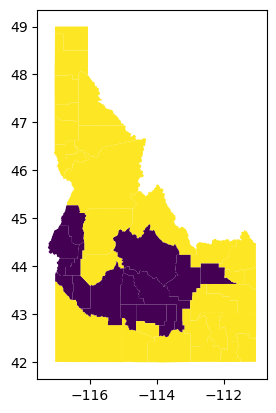

In [27]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()